***

<font color='green'>

# Project Solution: Computer Vision with CNN - Project 1 (Part 1)

#### Domain: Botanical Research

#### Context: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various stages of growth. They already have invested on curating sample images. They require an automation which can create a classifier capable of determining a plant's species from a photo

#### Purpose: University’s management require an automation which can create a classifier capable of determining a plant's species from a photo

#### Dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

#### Learning Outcome: Train and compare image classifier models using supervised learning classifier, neural network classifier and a CNN classifier.
***
***
*Prepared by: Sauvik De*

*Date: April 5, 2021*
    
</font>

***

In [1]:
#import sys
#!{sys.executable} -m pip install opencv-python

import os, glob, cv2

# Initialize the random number generator
import random
random.seed(1)

# Import necessary libraries
#import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

# import tensorflow
import tensorflow as tf

#### Read in image datafile

In [2]:
# Utility function to read in image files and pre-process
# =======================================================
def read_images_and_preprocess(folder, image_size=256):
    imageScaled = []
    imageNames = []
    fileNames = []
    imageShape = []
    for filename in glob.iglob(folder+'/**', recursive=True):
        if os.path.isfile(filename):
            img = cv2.imread(filename)
            # temp store image dimension/shape
            rawShape = img.shape
            # read in and resize image
            img = tf.keras.preprocessing.image.load_img(path=filename.replace('\\', '/')
                                                        , target_size=(image_size, image_size))
            # convert to 3D Numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img=img)
            # Scale pixel intensities to range between 0 and 1
            img_array = img_array * 1./255
            # Store the scaled image pixel intensities for image analysis (features)
            imageScaled.append(img_array)
            # Store image class (response categories)
            imageNames.append(os.path.basename(os.path.dirname(filename.replace('\\', '/'))))
            # Store image file name
            fileNames.append(os.path.basename(filename.replace('\\', '/')))
            # Store image dimension/shape
            imageShape.append(rawShape)
    # Convert scaled image pixel intensities to Numpy array of float type
    imageScaled = np.array(imageScaled, dtype=np.float32)
    return imageScaled, imageNames, fileNames, imageShape

In [3]:
# Define target image size that resizes all input images to 128 x 128
image_size = 128

In [4]:
# Read in training image files and pre-process
train_features, train_labels, train_fname, train_shape = \
            read_images_and_preprocess('Dataset - Plant-seedlings-classification/train', image_size=image_size)

In [5]:
# Read in test image files and pre-process
test_features, _, test_fname, test_shape = \
            read_images_and_preprocess('Dataset - Plant-seedlings-classification/test', image_size=image_size)

#### Analyze dimension of training image data

In [6]:
# Analyze dimension of training images
print('No. of training samples:', len(train_shape))
print('\nFirst 10 training images shapes:')
print(pd.DataFrame(train_shape, columns=['Width', 'Height', 'Depth']).head(10))
print('\nAverage raw training image shape:')
print(np.array(train_shape).mean(axis=0))
print('\nStd. Dev. of raw training image shape:')
print(np.array(train_shape).std(axis=0))
print('\nNote 1: All training images are colored (RGB) and almost squared.')
print('Note 2: Raw training images are of varying sizes with largest image size being', \
      np.array(train_shape).max(axis=0)[0:2], 'and smallest image size being', np.array(train_shape).min(axis=0)[0:2])

No. of training samples: 4750

First 10 training images shapes:
   Width  Height  Depth
0    196     196      3
1    388     388      3
2    886     886      3
3    117     117      3
4    471     471      3
5   1074    1074      3
6    251     251      3
7   1899    1900      3
8    531     531      3
9    352     352      3

Average raw training image shape:
[370.73010526 371.46589474   3.        ]

Std. Dev. of raw training image shape:
[318.61606329 323.24098098   0.        ]

Note 1: All training images are colored (RGB) and almost squared.
Note 2: Raw training images are of varying sizes with largest image size being [3457 3991] and smallest image size being [49 49]


In [7]:
# Scaled training image shapes
print('Scaled + resized training image shape:', train_features.shape)
print('\nScaled pixel intensities of training images lie between',  train_features.min(), 'and', train_features.max())
print('\nNote 1: Training images resized to squared images of size', train_features.shape[1])
print('Note 2: No. of training images:', train_features.shape[0])
print('Note 3: All training images are colored')

Scaled + resized training image shape: (4750, 128, 128, 3)

Scaled pixel intensities of training images lie between 0.0 and 1.0

Note 1: Training images resized to squared images of size 128
Note 2: No. of training images: 4750
Note 3: All training images are colored


In [8]:
# Training image labels
print('Training image labels:\n', set(train_labels))
print('\nThe number of training labels:', len(set(train_labels)))

Training image labels:
 {'Sugar beet', 'Maize', 'Common wheat', 'Small-flowered Cranesbill', 'Shepherds Purse', 'Charlock', 'Loose Silky-bent', 'Cleavers', 'Fat Hen', 'Scentless Mayweed', 'Common Chickweed', 'Black-grass'}

The number of training labels: 12


#### Visualize pre-processed training image data

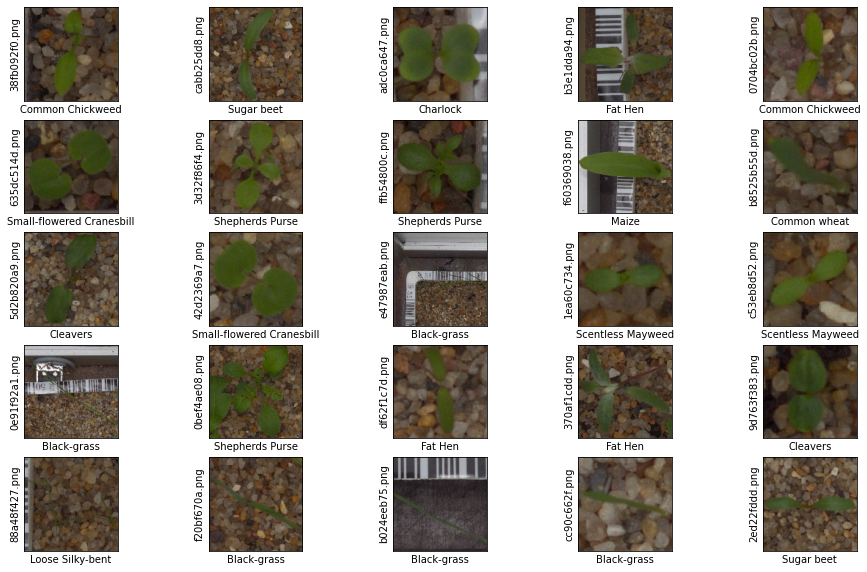

In [9]:
# Display 25 random images from training dataset
plt.figure(figsize=(16,10))
for i in range(25):
    j = random.randint(0,len(train_features)-1)
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_features[j])
    plt.xlabel(train_labels[j])
    plt.ylabel(train_fname[j])
plt.show()

#### Analyze dimension of test image data

In [10]:
# Analyze dimension of test images
print('No. of test samples:', len(test_shape))
print('\nFirst 10 test images shapes:')
print(pd.DataFrame(test_shape, columns=['Width', 'Height', 'Depth']).head(10))
print('\nAverage raw test image shape:')
print(np.array(test_shape).mean(axis=0))
print('\nStd. Dev. of raw test image shape:')
print(np.array(test_shape).std(axis=0))
print('\nNote 1: All test images are colored (RGB) and squared.')
print('Note 2: Raw test images are of varying sizes with largest image size being', \
      np.array(test_shape).max(axis=0)[0:2], 'and smallest image size being', np.array(test_shape).min(axis=0)[0:2])

No. of test samples: 794

First 10 test images shapes:
   Width  Height  Depth
0    270     270      3
1    253     253      3
2    288     288      3
3    214     214      3
4    313     313      3
5    283     283      3
6    259     259      3
7    204     204      3
8    231     231      3
9    269     269      3

Average raw test image shape:
[269.49244332 269.49244332   3.        ]

Std. Dev. of raw test image shape:
[43.08205595 43.08205595  0.        ]

Note 1: All test images are colored (RGB) and squared.
Note 2: Raw test images are of varying sizes with largest image size being [349 349] and smallest image size being [200 200]


In [11]:
# Scaled test image shapes
print('Scaled + resized test image shape:', test_features.shape)
print('\nScaled pixel intensities of test images lie between',  test_features.min(), 'and', test_features.max())
print('\nNote 1: Test images resized to squared images of size', test_features.shape[1])
print('Note 2: No. of test images:', test_features.shape[0])
print('Note 3: All test images are colored')

Scaled + resized test image shape: (794, 128, 128, 3)

Scaled pixel intensities of test images lie between 0.0 and 1.0

Note 1: Test images resized to squared images of size 128
Note 2: No. of test images: 794
Note 3: All test images are colored


#### Visualize pre-processed test image data

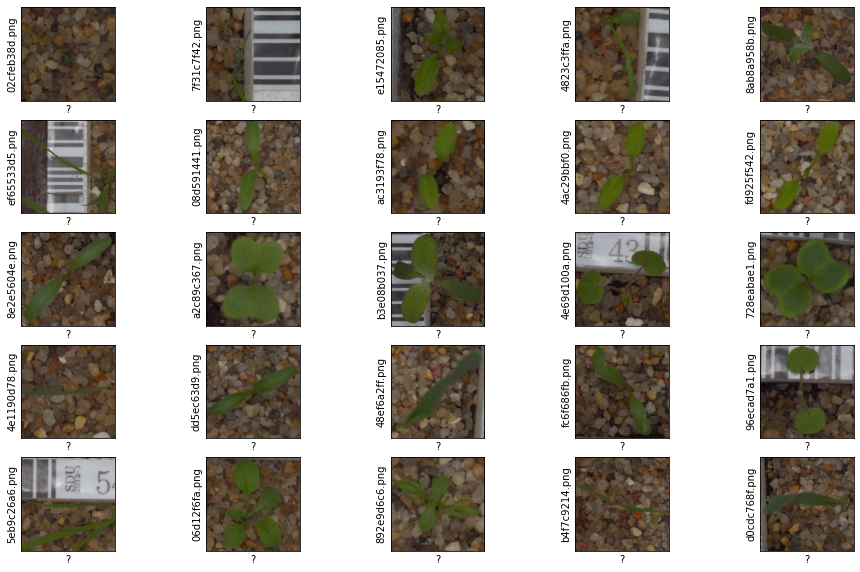

In [12]:
# Display 25 random images from test dataset with unknown labels
plt.figure(figsize=(16,10))
for i in range(25):
    j = random.randint(0,len(test_features)-1)
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_features[j])
    plt.xlabel('?')
    plt.ylabel(test_fname[j])
plt.show()

#### Analyze plant species categories using training data 

Frequency distribution of plant species:
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64


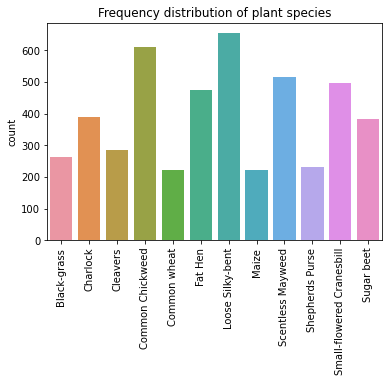

In [13]:
print('Frequency distribution of plant species:')
print(pd.Series(train_labels).value_counts())

#plt.figure(figsize=(16,9))
_ = sns.countplot(train_labels).set_title('Frequency distribution of plant species')
plt.xticks(rotation = 90)
plt.show()

- There are 12 plant species in training dataset
- Above histogram of training category labels indicates there is about 1:3 ratio betwen the least and the most frequent categories
- The training data doesn't seem to have any major class imbalance

#### Image classification model
- Given the task of image classification at hand, we can try various modelling techniques starting from supervised machine learning based models, to neural network deep learning model, to a more advanced computer vision model using Convolutional NN
- For modelling tasks, we need to ensure all the records are of the same size (i.e., having equal number of features or pixels)
- In addition, it is preferrable to scale the pixel intensities to lie between 0 and 1 for the efficiency of algorithms like gradient boosting
- So far we already completed preprocessing of the input pixel data (resizing images to same size and scaling pixel intensities)
- Further in order for us to use the pixel intensities in a model, we need to ensure the dimensions are flattened in 1-D to represent as features for each record

- Flatten and reshape both training and test datasets to be used in Machine Learning models

In [14]:
# calculate number of features for each record in training dataset
p = image_size * image_size * train_features.shape[3]

# flatten and reshape training dataset to make it ready for model ingestion
X_train_reshaped = train_features.flatten().reshape(len(train_features), p)

In [15]:
# Dimension of new reshaped feature dataset for training
X_train_reshaped.shape

(4750, 49152)

In [16]:
# calculate number of features for each record in test dataset
p = image_size * image_size * test_features.shape[3]

# flatten and reshape training dataset to make it ready for model ingestion
X_test_reshaped = test_features.flatten().reshape(len(test_features), p)

In [17]:
# Dimension of new reshaped feature dataset for test
X_test_reshaped.shape

(794, 49152)

In [18]:
# Label encode target label variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)

print('Shape of training label:', y_train_encoded.shape)

Shape of training label: (4750,)


In [19]:
##[This part is an additional process to feature generation using HOG - Historgram of Oriented Gradients]
##!{sys.executable} -m pip install scikit-image
#from skimage.color import rgb2gray
#from skimage.feature import hog

#features_list = []

#for i in range(len(X_train)):
    # flatten three channel color image
    #color_features = X_train[i].flatten()
    # convert image to greyscale
    #grey_image = rgb2gray(X_train[i])
    # get HOG (Histogram of Oriented Gradients) features from grayscale image
    #hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    #flat_features = np.hstack((color_features, hog_features))
    # Store in features_list
    #features_list.append(flat_features)

# convert list of arrays into a matrix
#feature_matrix = np.array(features_list)

#### Observation and strategy:
- Number of features for training images is 49152 which is extremely large compared to the number of samples (i.e., 4750)
- For applying supervised Machine Learning algorithms, we must reduce the dimension to make algorithms efficient and manageable
- We can use PCA to reduce the number of dimensions
- Features are already scaled between 0 and 1 and hence we will proceed without normalization (i.e., without Standard Scaling) for PCA
- In addition, we would split the training dataset into further training and validation sets in order to evaluate classification accuracy (i.e., model performance)

#### Split training dataset into training and validation sets

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_reshaped
                                                  , y_train_encoded
                                                  , test_size=0.20
                                                  , stratify=y_train_encoded
                                                  , shuffle=True
                                                  , random_state=100)

In [21]:
print('Dimension after train-validation split:')
print('[X_train, X_validation, y_train, y_validation] =', \
      [X_train.shape, X_val.shape, y_train.shape, y_val.shape])

Dimension after train-validation split:
[X_train, X_validation, y_train, y_validation] = [(3800, 49152), (950, 49152), (3800,), (950,)]


In [22]:
# Validate we have equal proportion of class representation from both training and validation sets
print('Frequency distribution of categories in training data:')
print(pd.Series(y_train).value_counts())

print('\nFrequency distribution of categories in validation data:')
print(pd.Series(y_val).value_counts())

Frequency distribution of categories in training data:
6     523
3     489
8     413
10    397
5     380
1     312
11    308
2     229
0     210
9     185
7     177
4     177
dtype: int64

Frequency distribution of categories in validation data:
6     131
3     122
8     103
10     99
5      95
1      78
11     77
2      58
0      53
9      46
7      44
4      44
dtype: int64


In [23]:
## Run principal component on training part of dataset to determine number of suitable principal components
#pca = PCA(random_state=100)
#pca.fit(X_train)
#cumsum = np.cumsum(pca.explained_variance_ratio_)

## Analysis of number of principal components required for explaining variability in feature space
#propvar = np.arange(start=0.70, stop=1.00, step=0.025)
#numcomp = []
#for k in propvar:
    #numcomp.append(np.argmax(cumsum >= k) + 1)

#pcinfo = pd.DataFrame(data={'% of variability explained':propvar, '# principal components required':numcomp})
#_ = sns.lineplot(x = pcinfo.iloc[:-1,0], y = pcinfo.iloc[:-1,1]).set_title('# Principal Components vs % of explained variance')

#print('\n# principal components attributing to percentage of explained variance in feature space:')
#pcinfo[:-1]

In [24]:
# Fit PCA on training dataset using components that can explain 80% of cumulative variance in feature space
pca = PCA(n_components=0.80, svd_solver='full', random_state=100)
X_train_pca80 = pca.fit_transform(X_train)

print('Reduced shape of training dataset after applying PCA', X_train_pca80.shape)
print('Prop. of variability in original feature space explained:', np.sum(pca.explained_variance_ratio_))

# Prepare reduced feature set for validation data 
X_val_pca80 = pca.transform(X_val)

print('Reduced shape of validation dataset after applying PCA', X_val_pca80.shape)

Reduced shape of training dataset after applying PCA (3800, 280)
Prop. of variability in original feature space explained: 0.80006266
Reduced shape of validation dataset after applying PCA (950, 280)


In [25]:
# Fit PCA on training dataset using components that can explain 85% of cumulative variance in feature space
pca = PCA(n_components=0.85, svd_solver='full', random_state=100)
X_train_pca85 = pca.fit_transform(X_train)

print('Reduced shape of training dataset after applying PCA', X_train_pca85.shape)
print('Prop. of variability in original feature space explained:', np.sum(pca.explained_variance_ratio_))

# Prepare reduced feature set for validation data 
X_val_pca85 = pca.transform(X_val)

print('Reduced shape of validation dataset after applying PCA', X_val_pca85.shape)

Reduced shape of training dataset after applying PCA (3800, 452)
Prop. of variability in original feature space explained: 0.8500672
Reduced shape of validation dataset after applying PCA (950, 452)


In [26]:
# Fit PCA on training dataset using components that can explain 90% of cumulative variance in feature space
pca = PCA(n_components=0.90, svd_solver='full', random_state=100)
X_train_pca90 = pca.fit_transform(X_train)

print('Reduced shape of training dataset after applying PCA', X_train_pca90.shape)
print('Prop. of variability in original feature space explained:', np.sum(pca.explained_variance_ratio_))

# Prepare reduced feature set for validation data
X_val_pca90 = pca.transform(X_val)

print('Reduced shape of validation dataset after applying PCA', X_val_pca90.shape)

Reduced shape of training dataset after applying PCA (3800, 742)
Prop. of variability in original feature space explained: 0.900083
Reduced shape of validation dataset after applying PCA (950, 742)


In [27]:
# Fit PCA on training dataset using components that can explain 95% of cumulative variance in feature space
pca = PCA(n_components=0.95, svd_solver='full', random_state=100)
X_train_pca95 = pca.fit_transform(X_train)

print('Reduced shape of training dataset after applying PCA', X_train_pca95.shape)
print('Prop. of variability in original feature space explained:', np.sum(pca.explained_variance_ratio_))

# Prepare reduced feature set for validation data 
X_val_pca95 = pca.transform(X_val)

print('Reduced shape of validation dataset after applying PCA', X_val_pca95.shape)

Reduced shape of training dataset after applying PCA (3800, 1281)
Prop. of variability in original feature space explained: 0.950015
Reduced shape of validation dataset after applying PCA (950, 1281)


- Looking at the principal component analysis, it looks like we can reduce the dimension of feature space substantially
- Starting from 49152 original features, we can reduce the dimension to 742 and 1281 to explain 90% and 95% of variability in feature space respectively

In [28]:
## Test: Re-verify training images through reconstruction of images to original space using PCA-applied reduced dimensioned images 
## Retrieving the results of the image after dimension reduction
#X_train_pca_rev = pca.inverse_transform(X_train_pca95)
#X_train_pca_rev = np.reshape(X_train_pca_rev, (len(X_train_pca95), image_size, image_size, 3))

## Display 25 random images from reconstructed training dataset
#plt.figure(figsize=(16,10))
#for i in range(25):
    #j = random.randint(0,len(X_train_pca_rev)-1)
    #plt.subplot(5,5,i+1)
    #plt.grid(False)
    #plt.xticks([])
    #plt.yticks([])
    #plt.imshow((X_train_pca_rev[j] * 255).astype(np.uint8))
    #plt.xlabel(le.inverse_transform(y_train)[j])
#plt.show()

#### Supervised ML modelling:
- Given SVM's known effectiveness in high dimensional spaces, my first choice of supervised ML model is Support Vector Classifier for this multi-class image classification task
- Other alternative classifier choices of ML models may be Decision Tree, Random Forest, Stochastic Gradient Descent, Gaussian Naive Bayes

In [164]:
# Fit SVC on training dataset (PCA-applied)
for C in [0.1,1,10,100,1000]:
    for kernel in ['poly','rbf']:
        svc = SVC(C=C, kernel=kernel)
        svc.fit(X_train_pca90, y_train)
        
        # Print model performance
        print('C=',C, ', kernel=', kernel, ': Training accuracy=', accuracy_score(y_train, svc.predict(X_train_pca90))
              , ', Validation accuracy=', accuracy_score(y_val, svc.predict(X_val_pca90))
             )

C= 0.1 , kernel= poly : Training accuracy= 0.26921052631578946 , Validation accuracy= 0.15263157894736842
C= 0.1 , kernel= rbf : Training accuracy= 0.2536842105263158 , Validation accuracy= 0.23684210526315788
C= 1 , kernel= poly : Training accuracy= 0.4328947368421053 , Validation accuracy= 0.1736842105263158
C= 1 , kernel= rbf : Training accuracy= 0.8518421052631578 , Validation accuracy= 0.508421052631579
C= 10 , kernel= poly : Training accuracy= 0.8486842105263158 , Validation accuracy= 0.33473684210526317
C= 10 , kernel= rbf : Training accuracy= 0.9997368421052631 , Validation accuracy= 0.5673684210526316
C= 100 , kernel= poly : Training accuracy= 1.0 , Validation accuracy= 0.42
C= 100 , kernel= rbf : Training accuracy= 1.0 , Validation accuracy= 0.5663157894736842
C= 1000 , kernel= poly : Training accuracy= 1.0 , Validation accuracy= 0.42105263157894735
C= 1000 , kernel= rbf : Training accuracy= 1.0 , Validation accuracy= 0.5663157894736842


- C=10 with rbf kernel seems to provide the best validation accuracy of 57% - however, clearly the model is highly overfit
- C=1 with rbf kernel gets validation accuracy of 50% with this model being slightly better in terms of overfit
- Since there is a lot of features, we may want to reduce dimension to see if there is any improvement in fitting
- Let's try SVC model using a few different principal components (and hence different number of features) next

In [174]:
# Fit SVC on training dataset (PCA-applied)
for C in [0.1,1,10,100,1000]:
    for kernel in ['poly','rbf']:
        svc = SVC(C=C, kernel=kernel)
        svc.fit(X_train_pca80, y_train)
        
        # Print model performance
        print('C=',C, ', kernel=', kernel, ': Training accuracy=', accuracy_score(y_train, svc.predict(X_train_pca80))
              , ', Validation accuracy=', accuracy_score(y_val, svc.predict(X_val_pca80))
             )

C= 0.1 , kernel= poly : Training accuracy= 0.2723684210526316 , Validation accuracy= 0.16
C= 0.1 , kernel= rbf : Training accuracy= 0.26552631578947367 , Validation accuracy= 0.2557894736842105
C= 1 , kernel= poly : Training accuracy= 0.42605263157894735 , Validation accuracy= 0.18105263157894738
C= 1 , kernel= rbf : Training accuracy= 0.8173684210526316 , Validation accuracy= 0.5157894736842106
C= 10 , kernel= poly : Training accuracy= 0.7921052631578948 , Validation accuracy= 0.35578947368421054
C= 10 , kernel= rbf : Training accuracy= 0.9968421052631579 , Validation accuracy= 0.5568421052631579
C= 100 , kernel= poly : Training accuracy= 0.995 , Validation accuracy= 0.4305263157894737
C= 100 , kernel= rbf : Training accuracy= 1.0 , Validation accuracy= 0.5442105263157895
C= 1000 , kernel= poly : Training accuracy= 1.0 , Validation accuracy= 0.4368421052631579
C= 1000 , kernel= rbf : Training accuracy= 1.0 , Validation accuracy= 0.5442105263157895


- Very similar conclusion as before - C=1 with rbf kernel seems to be the most optimum performing model - but still an overfit (training accuracy 82% vs validation accuracy 52%)

In [37]:
# Let's try Decision Tree on training set (PCA-applied)
for msl in [5,10,25,50,100]:
    for md in [None,10,20,50]:
        for crit in ['gini', 'entropy']:
            dt = DecisionTreeClassifier(criterion=crit, min_samples_leaf=msl, max_depth=md, random_state=100)
            dt.fit(X_train_pca90, y_train)
            
            # Print model performance
            print('Criteria=', crit, ', Min_Samples_Leaf=',msl, ', Max_Depth=', md
                  , ': Training accuracy=', accuracy_score(y_train, dt.predict(X_train_pca90))
                  , ', Validation accuracy=', accuracy_score(y_val, dt.predict(X_val_pca90))
                 )

Criteria= gini , Min_Samples_Leaf= 5 , Max_Depth= None : Training accuracy= 0.7276315789473684 , Validation accuracy= 0.1863157894736842
Criteria= entropy , Min_Samples_Leaf= 5 , Max_Depth= None : Training accuracy= 0.7528947368421053 , Validation accuracy= 0.19473684210526315
Criteria= gini , Min_Samples_Leaf= 5 , Max_Depth= 10 : Training accuracy= 0.5471052631578948 , Validation accuracy= 0.20421052631578948
Criteria= entropy , Min_Samples_Leaf= 5 , Max_Depth= 10 : Training accuracy= 0.6552631578947369 , Validation accuracy= 0.1957894736842105
Criteria= gini , Min_Samples_Leaf= 5 , Max_Depth= 20 : Training accuracy= 0.7276315789473684 , Validation accuracy= 0.1863157894736842
Criteria= entropy , Min_Samples_Leaf= 5 , Max_Depth= 20 : Training accuracy= 0.7528947368421053 , Validation accuracy= 0.19473684210526315
Criteria= gini , Min_Samples_Leaf= 5 , Max_Depth= 50 : Training accuracy= 0.7276315789473684 , Validation accuracy= 0.1863157894736842
Criteria= entropy , Min_Samples_Leaf= 5

- Looking at the Decision Tree results, model overfits with small values of min_samples_leaf (5) as expected, however, as we increase the min_samples_leaf (100), model tends to underfit with no significant lift in accuracy
- We can rather try with RandomForest to check accuracies

In [30]:
# Let's try Random Forest on training set (PCA-applied)
nes = []
msls = []
mds = []
crits = []
trainAcc = []
valAcc = []

for ne in [51,101,151,201]:
    for msl in [5,10,25,50,100]:
        for md in [None,10,20,50]:
            for crit in ['gini', 'entropy']:
                rf = RandomForestClassifier(criterion=crit
                                            , n_estimators=ne
                                            , min_samples_leaf=msl
                                            , max_depth=md
                                            , oob_score=False
                                            , n_jobs=-1
                                            , random_state=100)
                rf.fit(X_train_pca90, y_train)
            
                # Store model specs and performance
                nes.append(ne)
                msls.append(msl)
                mds.append(md)
                crits.append(crit)
                trainAcc.append(accuracy_score(y_train, rf.predict(X_train_pca90)))
                valAcc.append(accuracy_score(y_val, rf.predict(X_val_pca90)))

rfOut = pd.DataFrame({'criterion':crits, 'n_estimators':nes, 'min_samples_leaf':msls, 'max_depth':mds
                      , 'TrainAcc':trainAcc, 'ValidationAcc':valAcc})

In [49]:
rfOut.sort_values(by='ValidationAcc', ascending=False).head(5)

criterion  n_estimators  min_samples_leaf  max_depth  TrainAcc  \
124      gini           201                 5       20.0  1.000000   
132      gini           201                10       20.0  0.951053   
128      gini           201                10        NaN  0.950526   
134      gini           201                10       50.0  0.950526   
122      gini           201                 5       10.0  0.903684   

     ValidationAcc  
124       0.356842  
132       0.352632  
128       0.350526  
134       0.350526  
122       0.345263

In [50]:
rfOut.sort_values(by='ValidationAcc', ascending=False).tail(5)

criterion  n_estimators  min_samples_leaf  max_depth  TrainAcc  \
35   entropy            51               100       10.0  0.328947   
37   entropy            51               100       20.0  0.328947   
39   entropy            51               100       50.0  0.328947   
33   entropy            51               100        NaN  0.328947   
32      gini            51               100        NaN  0.347105   

    ValidationAcc  
35       0.271579  
37       0.271579  
39       0.271579  
33       0.271579  
32       0.281053

- Looking at the above result of Random Forest, validation accuracy ranges between 28% and 36%; wth small values of min_samples_leaf leading an overfit
- Random Forest model doesn't seem to work well too for this image classification task
- This may be reasonable due to inherent complexity in high dimensional data
- We can try Xtreme Gradient Boosting to see how the performance looks like

In [31]:
# Let's try XGB on PCA-applied training dataset
nes = []
lrs = []
mds = []
trainAcc = []
valAcc = []

for ne in [101,201]:
    for lr in [0.0001, 0.001, 0.01, 0.1]:
        for md in [None,50,100]:
            xgb = XGBClassifier(objective='multi:softmax'
                                , n_estimators=ne
                                , learning_rate=lr
                                , max_depth=md
                                , n_jobs=-1
                                , random_state=100)
            xgb.fit(X_train_pca90, y_train)
            
            # Store model specs and performance
            nes.append(ne)
            lrs.append(lr)
            mds.append(md)
            trainAcc.append(accuracy_score(y_train, xgb.predict(X_train_pca90)))
            valAcc.append(accuracy_score(y_val, xgb.predict(X_val_pca90)))

xgbOut = pd.DataFrame({'n_estimators':nes, 'learning_rate':lrs, 'max_depth':mds
                       , 'TrainAcc':trainAcc, 'ValidationAcc':valAcc})

In [55]:
xgbOut.sort_values(by='ValidationAcc', ascending=False).head(5)

n_estimators  learning_rate  max_depth  TrainAcc  ValidationAcc
25            51            0.3        NaN       1.0       0.444211
20            51            0.2        NaN       1.0       0.440000
22            51            0.2       20.0       1.0       0.426316
26            51            0.3       10.0       1.0       0.423158
21            51            0.2       10.0       1.0       0.415789

In [56]:
xgbOut.sort_values(by='ValidationAcc', ascending=False).tail(5)

n_estimators  learning_rate  max_depth  TrainAcc  ValidationAcc
1             51         0.0001       10.0  0.862368       0.240000
32           101         0.0001       20.0  0.926053       0.238947
31           101         0.0001       10.0  0.865526       0.236842
33           101         0.0001       50.0  0.929211       0.236842
34           101         0.0001      100.0  0.929211       0.236842

- From the Xtreme Gradient Boosting result, models are largely overfit with validation accuracy ranging between 24% to 44%
- We found Support Vector Classifier to be best performing among various Machine Learning models considered
- However, the performance of Support Vector Classifier is still not at par and an overfit (only about 51% validation accuracy vs 85% training accuracy)
- Given the inherent complexity in image dataset, generally the machine learning models tend to miss out on learning through a single pass.
- As there is knowledge that can be incorporated into the learning through "continuous" tuning of parameter weights (concept of backpropagation) like the way deep learning (DL) models work, these DL models may be more suited for this image classification task
- Thus it may be expected that Artificial Neural Network might perform better than ML models - so let's try it next

#### Deep Learning model  - Artificial Neural Network (ANN)

In [28]:
def create_model(input_size #should be number of features for input 2-D array
                 , output_size #should be number of output nodes (# classes for multiclass classification)
                 , numLayers=3
                 , numNeurons=[256, 128, 64]
                 , activation_fn=[tf.keras.layers.LeakyReLU(alpha=0.3)]*3
                 , kernel_initializer=[tf.keras.initializers.glorot_uniform(seed=7)]*3
                 , bn=[True]*3
                 , dropout_rate=[0.20, 0.10, 0.05]
                 , output_activation_fn='softmax'
                 , optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025)
                ):
    
    if((numLayers==len(numNeurons)) & (numLayers==len(activation_fn)) & (numLayers==len(kernel_initializer)) \
            & (numLayers==len(dropout_rate)) & (numLayers==len(bn))):
        
        # Initialize sequential Network
        model = tf.keras.Sequential()

        # Reshape the input of m x m image into 1d array with m^2 features
        #model.add(tf.keras.layers.Reshape(target_shape=(image_size*image_size*3,), input_shape=(image_size*image_size*3,)))

        # Build layers
        for l in range(numLayers):

            if(l==0):
                # Add first layer + shape of input
                model.add(tf.keras.layers.Dense(units=numNeurons[0], activation=activation_fn[0]
                                                , kernel_initializer=kernel_initializer[0]
                                                , input_shape=(input_size,)))
            else:
                # Add second network layers onwards
                model.add(tf.keras.layers.Dense(units=numNeurons[l], activation=activation_fn[l]
                                                , kernel_initializer=kernel_initializer[l]))

            # Add batch normalization
            if(bn[l]):
                model.add(tf.keras.layers.BatchNormalization())

            # Add dropout rates for regularization + avoid overfitting
            model.add(tf.keras.layers.Dropout(rate=dropout_rate[l]))

        # Output Layer with number of neurons (= # of classes) and softmax activation function
        model.add(tf.keras.layers.Dense(units=output_size, activation=output_activation_fn))

        # Compile model
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return(model)
    else:
        raise ValueError('Incompatible model specifications. Please review model architecture input.')

#### Prepare dataset for Neural Network

In [99]:
# One-Hot-Encode target variable
train_labels_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(set(y_train)))
val_labels_encoded = tf.keras.utils.to_categorical(y_val, num_classes=len(set(y_val)))

In [31]:
# Build NN model and fit on training dataset
model1 = create_model(input_size=X_train.shape[1]
                      , output_size=train_labels_encoded.shape[1]
                      , numLayers=5
                      , numNeurons=[1024,512,256,128,64]
                      , activation_fn=[tf.keras.layers.LeakyReLU(alpha=0.3)]*5
                      , kernel_initializer=[tf.keras.initializers.glorot_uniform(seed=7)]*5
                      , bn=[False]*5
                      , dropout_rate=[0.30,0.20,0.10,0.10,0.05]
                      , output_activation_fn='softmax'
                      , optimizer=tf.keras.optimizers.Adam())

# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# Train model
hist1 = model1.fit(X_train, train_labels_encoded, batch_size=128, epochs=200, verbose=1,
                   validation_data=(X_val, val_labels_encoded), callbacks=[callback])

Train on 3800 samples, validate on 950 samples
Epoch 1/200
3800/3800 [==============================] - 13s 3ms/sample - loss: 11.4901 - accuracy: 0.1011 - val_loss: 2.5696 - val_accuracy: 0.1000
Epoch 2/200
3800/3800 [==============================] - 12s 3ms/sample - loss: 3.1833 - accuracy: 0.1103 - val_loss: 2.4227 - val_accuracy: 0.1158
Epoch 3/200
3800/3800 [==============================] - 12s 3ms/sample - loss: 2.6264 - accuracy: 0.1247 - val_loss: 2.3794 - val_accuracy: 0.1747
Epoch 4/200
3800/3800 [==============================] - 12s 3ms/sample - loss: 2.4956 - accuracy: 0.1413 - val_loss: 2.3617 - val_accuracy: 0.1389
Epoch 5/200
3800/3800 [==============================] - 12s 3ms/sample - loss: 2.4365 - accuracy: 0.1650 - val_loss: 2.3109 - val_accuracy: 0.1853
Epoch 6/200
3800/3800 [==============================] - 12s 3ms/sample - loss: 2.3916 - accuracy: 0.1818 - val_loss: 2.2580 - val_accuracy: 0.2368
Epoch 7/200
3800/3800 [==============================] - 12s 3ms

Epoch 56/200
3800/3800 [==============================] - 3909s 1s/sample - loss: 1.3248 - accuracy: 0.5376 - val_loss: 1.4155 - val_accuracy: 0.5147
Epoch 57/200
3800/3800 [==============================] - 12s 3ms/sample - loss: 1.1125 - accuracy: 0.5926 - val_loss: 1.5211 - val_accuracy: 0.4842
Epoch 58/200
3800/3800 [==============================] - 10s 3ms/sample - loss: 1.0917 - accuracy: 0.6097 - val_loss: 1.4976 - val_accuracy: 0.5168
Epoch 59/200
3800/3800 [==============================] - 10s 3ms/sample - loss: 1.1617 - accuracy: 0.5834 - val_loss: 1.6280 - val_accuracy: 0.4884
Epoch 60/200
3800/3800 [==============================] - 10s 3ms/sample - loss: 1.2109 - accuracy: 0.5574 - val_loss: 1.3933 - val_accuracy: 0.5653
Epoch 61/200
3800/3800 [==============================] - 10s 3ms/sample - loss: 1.2623 - accuracy: 0.5613 - val_loss: 1.5587 - val_accuracy: 0.4737
Epoch 62/200
3800/3800 [==============================] - 9s 2ms/sample - loss: 1.1472 - accuracy: 0.5784

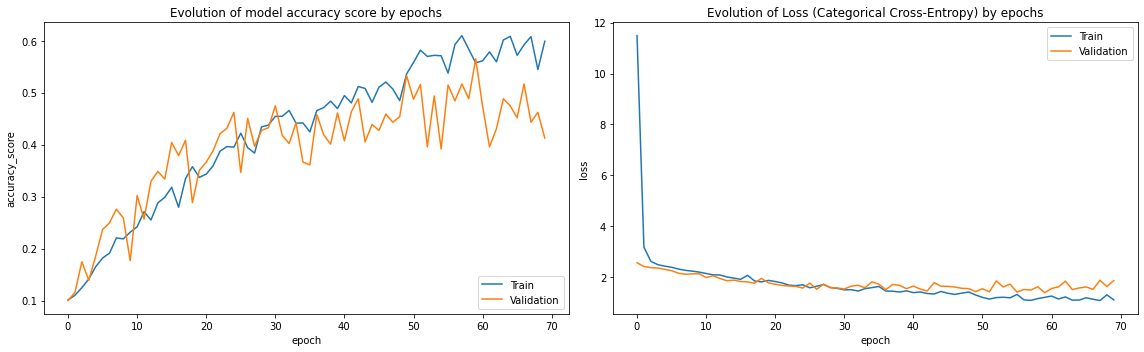

In [32]:
hist = hist1

plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [33]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model1.evaluate(X_val, val_labels_encoded, batch_size=128)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

950/950 [==============================] - 1s 851us/sample - loss: 1.3933 - accuracy: 0.5653
Validation cross-entropy Loss: 1.3933314516669826
Validation classification Accuracy: 0.56526315


In [34]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model1.evaluate(X_train, train_labels_encoded, batch_size=128)
print('Training cross-entropy Loss:', loss)
print('Training classification Accuracy:', accuracy)

3800/3800 [==============================] - 3s 906us/sample - loss: 0.8085 - accuracy: 0.7518
Training cross-entropy Loss: 0.8084909023736653
Training classification Accuracy: 0.7518421


- In the above model, we used the training dataset with all the features (49000+) included without any batch normalization
- The model underfits and hence we will first try to make model overfit and then further tune parameters and regularization to control overfit
- We can reduce the number of features, i.e., we can use PCA-applied features for training (say, first 742 principal components explaining 90% of variability in feature space). This would speed up learning and also may potentially improve the model performance

In [35]:
# Build NN model and fit on training dataset
model2 = create_model(input_size=X_train_pca90.shape[1]
                      , output_size=train_labels_encoded.shape[1]
                      , numLayers=5
                      , numNeurons=[256,256,128,128,64]
                      , activation_fn=[tf.keras.layers.LeakyReLU(alpha=0.3)]*5
                      , kernel_initializer=[tf.keras.initializers.glorot_uniform(seed=7)]*5
                      , bn=[True]*5
                      , dropout_rate=[0.30,0.30,0.20,0.10,0.05]
                      , output_activation_fn='softmax'
                      , optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')

# Train model
hist2 = model2.fit(X_train_pca90, train_labels_encoded, batch_size=128, epochs=200, verbose=1,
                   validation_data=(X_val_pca90, val_labels_encoded), callbacks=[callback])

Train on 3800 samples, validate on 950 samples
Epoch 1/200
3800/3800 [==============================] - 3s 766us/sample - loss: 2.7128 - accuracy: 0.1508 - val_loss: 2.2084 - val_accuracy: 0.2863
Epoch 2/200
3800/3800 [==============================] - 1s 146us/sample - loss: 2.0088 - accuracy: 0.3150 - val_loss: 1.8538 - val_accuracy: 0.4032
Epoch 3/200
3800/3800 [==============================] - 1s 252us/sample - loss: 1.6882 - accuracy: 0.4258 - val_loss: 1.6354 - val_accuracy: 0.4505
Epoch 4/200
3800/3800 [==============================] - 1s 295us/sample - loss: 1.4896 - accuracy: 0.4797 - val_loss: 1.5178 - val_accuracy: 0.4821
Epoch 5/200
3800/3800 [==============================] - 1s 149us/sample - loss: 1.3240 - accuracy: 0.5358 - val_loss: 1.4338 - val_accuracy: 0.4905
Epoch 6/200
3800/3800 [==============================] - 1s 228us/sample - loss: 1.1829 - accuracy: 0.5884 - val_loss: 1.3932 - val_accuracy: 0.5200
Epoch 7/200
3800/3800 [==============================] - 1s

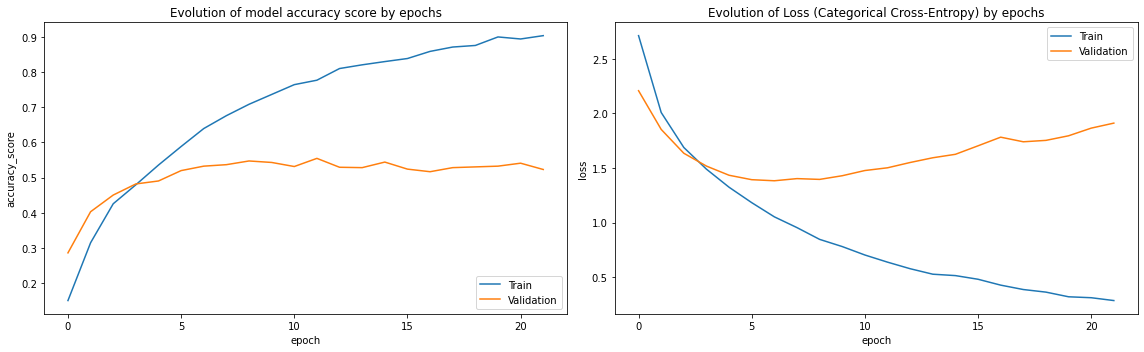

In [36]:
hist = hist2

plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [37]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model2.evaluate(X_val_pca90, val_labels_encoded, batch_size=128)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

950/950 [==============================] - 0s 49us/sample - loss: 1.5022 - accuracy: 0.5547
Validation cross-entropy Loss: 1.5021570007424605
Validation classification Accuracy: 0.55473685


In [38]:
# Obtain cross-entropy loss and accuracy scores on training dataset
loss, accuracy = model2.evaluate(X_train_pca90, train_labels_encoded, batch_size=128)
print('Training cross-entropy Loss:', loss)
print('Training classification Accuracy:', accuracy)

3800/3800 [==============================] - 0s 35us/sample - loss: 0.2619 - accuracy: 0.9347
Training cross-entropy Loss: 0.26185509138985685
Training classification Accuracy: 0.93473685


- The above model is based on training dataset on reduced dimension (742 principal components) with both batch normalization and dropouts applied.
- Traning is faster and we are able to improve training accuracy compared to earlier
- However, the model is still an overfit and unable to generalize on unseen dataset (validation accuracy 55% vs training accuracy 93%). We need to try regularization further.

In [221]:
## Build NN model and fit on training dataset
model3 = create_model(input_size=X_train_pca90.shape[1]
                      , output_size=train_labels_encoded.shape[1]
                      , numLayers=5
                      , numNeurons=[512,256,128,128,64]
                      , activation_fn=[tf.keras.layers.ReLU()]*5
                      #, activation_fn=[tf.keras.activations.tanh]*5
                      , kernel_initializer=[tf.keras.initializers.glorot_normal(seed=7)]*5
                      , bn=[True]*5
                      , dropout_rate=[0.45,0.30,0.15,0.10,0.05]
                      , output_activation_fn='softmax'
                      , optimizer=tf.keras.optimizers.Adam(learning_rate=0.002))

# Set early stopping criteria (i.e., no improvement in validation loss in 10 successive epochs)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')

# Train model
hist3 = model3.fit(X_train_pca90, train_labels_encoded, batch_size=64, epochs=200, verbose=1,
                   validation_data=(X_val_pca90, val_labels_encoded), callbacks=[callback])

Train on 3800 samples, validate on 950 samples
Epoch 1/200
3800/3800 [==============================] - 2s 511us/sample - loss: 2.6639 - accuracy: 0.1503 - val_loss: 2.2588 - val_accuracy: 0.2547
Epoch 2/200
3800/3800 [==============================] - 1s 147us/sample - loss: 2.0212 - accuracy: 0.3058 - val_loss: 1.7923 - val_accuracy: 0.3821
Epoch 3/200
3800/3800 [==============================] - 1s 151us/sample - loss: 1.6703 - accuracy: 0.4074 - val_loss: 1.5363 - val_accuracy: 0.4842
Epoch 4/200
3800/3800 [==============================] - 1s 154us/sample - loss: 1.3764 - accuracy: 0.5113 - val_loss: 1.4638 - val_accuracy: 0.5168
Epoch 5/200
3800/3800 [==============================] - 1s 150us/sample - loss: 1.1561 - accuracy: 0.5989 - val_loss: 1.4822 - val_accuracy: 0.5316
Epoch 6/200
3800/3800 [==============================] - 1s 150us/sample - loss: 1.0010 - accuracy: 0.6487 - val_loss: 1.4949 - val_accuracy: 0.5453
Epoch 7/200
3800/3800 [==============================] - 1s

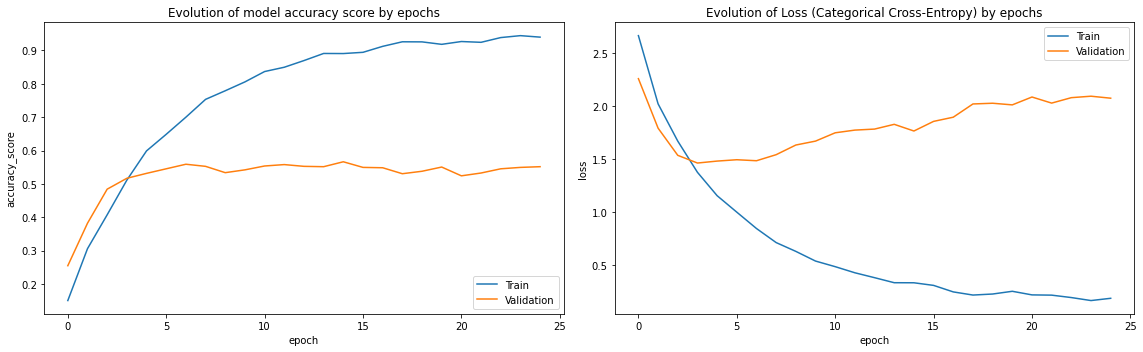

In [222]:
hist = hist3

plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [224]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = model3.evaluate(X_val_pca90, val_labels_encoded, batch_size=64)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

950/950 [==============================] - 0s 48us/sample - loss: 1.7655 - accuracy: 0.5663
Validation cross-entropy Loss: 1.7655460091641075
Validation classification Accuracy: 0.56631577


In [225]:
# Obtain cross-entropy loss and accuracy scores on training dataset
loss, accuracy = model3.evaluate(X_train_pca90, train_labels_encoded, batch_size=64)
print('Training cross-entropy Loss:', loss)
print('Training classification Accuracy:', accuracy)

3800/3800 [==============================] - 0s 45us/sample - loss: 0.0313 - accuracy: 0.9947
Training cross-entropy Loss: 0.031280215433553644
Training classification Accuracy: 0.99473685


- We ran a few iterations using various settings of batch normalization, activation functions, dropout rates, optimizers, batch size.
- The above model yielded the highest validation accuracy (~57%) but still the model is largely an overfit, and hence may not be usable on unseen production data
- As it turns out, simple ANN models may not work great given the inherent complexity of the images like shades, noises, flips
- Moreover, that the neural networks are data-hungry models, it tends to work great on a large amount of data. In our case, the training set size is only 3800 which makes the task for the simple ANN even more harder.
- We can try image augmentation to increase the size of samples along with random rotation, shifts, flips and shear
- In addition, we can try filtering (like Gaussian blurring etc.) and other data pre-processing (ConvNet) in the framework of Convolutional Neural Networks (CNN) before we apply Neural Network model (i.e., feedforward + backpropagation).
- We may expect CNN with appropriate image augmentation and data pre-processing may help improve the model prediction for the task of seedling classification at hand

#### Deep Learning model  - Convolutional Neural Network (CNN)

In [24]:
# Reshape feature set to make compatible with CNN convnet input
X_train_exp = X_train.reshape(len(X_train), image_size, image_size, 3)
X_val_exp = X_val.reshape(len(X_val), image_size, image_size, 3)

print('The modified shape for X_train:', X_train_exp.shape)
print('The modified shape for X_val:', X_val_exp.shape)

The modified shape for X_train: (3800, 128, 128, 3)
The modified shape for X_val: (950, 128, 128, 3)


- As noted earlier, sample size is not large enough for training deep learning model, so we can try with image augmentation to facilitate more samples. This will also bring in more varieties in data with the inclusion of random rotation, shifts, flips.

In [128]:
# Augmented image generator
imgdatagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30 #Degree range for random rotations
                                                             , width_shift_range=0.2 #Randomly shift input horizontally
                                                             , height_shift_range=0.2 #Randomly shift input vertically
                                                             , horizontal_flip=True #Randomly flip input horizontally
                                                             , vertical_flip=True #Randomly flip input vertically
                                                            )

In [129]:
# Fit image data generator on training set 
imgdatagen.fit(X_train_exp)

# Configure the batch size and prepare the data generator and get batches of training images
train_datagen = imgdatagen.flow(x=X_train_exp, y=train_labels_encoded, batch_size=8)

# Configure the batch size and prepare the data generator and get batches of validation images
val_datagen = imgdatagen.flow(x=X_val_exp, y=val_labels_encoded, batch_size=8)

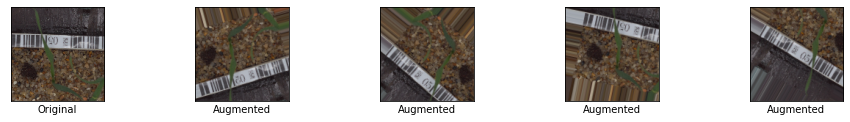

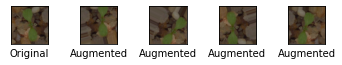

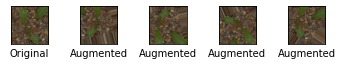

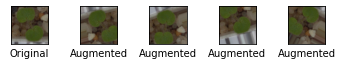

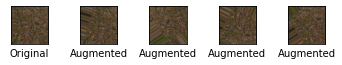

In [130]:
# Visualize augmented images
plt.figure(figsize=(16,10))

# randomly select 5 images
X_train_rs = []
for i in range(5):
    j = random.randint(0,len(X_train_exp)-1)
    x_train_rs = X_train_exp[j].reshape(1, image_size, image_size, 3)
    
    gen = imgdatagen.flow(x_train_rs, batch_size=4)
    
    for k in range(1,6):
        plt.subplot(5,5,k)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        if k == 1:
            plt.imshow(x_train_rs.squeeze())
            plt.xlabel('Original')
        else:
            plt.imshow(gen.next().squeeze())
            plt.xlabel('Augmented')
    _ = plt.show()

- We will use augmented images as part of training samples to add more varieties and hence larger sample size

In [131]:
# Clear Keras managed global state memory
tf.keras.backend.clear_session()

# Initialize model
mdl1 = tf.keras.models.Sequential()

# Set up input image size
mdl1.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,)))

# Define input shape in the first layer of the neural network
#mdl1.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(x_train.shape[1:])))

# Add Convolutional layer
mdl1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu'))
# Add Batch Normalization layer
mdl1.add(tf.keras.layers.BatchNormalization())

# Add Convolutional layer
mdl1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'))
# Add Max Pooling layer
mdl1.add(tf.keras.layers.MaxPooling2D((2,2)))
# Add Batch Normalization layer
mdl1.add(tf.keras.layers.BatchNormalization())

# Add Convolutional layer
mdl1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu'))
# Add Max Pooling layer
mdl1.add(tf.keras.layers.MaxPooling2D((3,3)))
# Add Batch Normalization layer
mdl1.add(tf.keras.layers.BatchNormalization())

# Add Max Pooling layer
mdl1.add(tf.keras.layers.GlobalMaxPool2D())

# Flatten
mdl1.add(tf.keras.layers.Flatten())

# Add FC dense layer
mdl1.add(tf.keras.layers.Dense(units=256, activation='relu'))
# Add Dropout
mdl1.add(tf.keras.layers.Dropout(0.5))
# Add FC dense layer
mdl1.add(tf.keras.layers.Dense(units=256, activation='relu'))
# Add Dropout
mdl1.add(tf.keras.layers.Dropout(0.4))

# Add Output layer
mdl1.add(tf.keras.layers.Dense(units=train_labels_encoded.shape[1], activation='softmax'))

# Compile model
mdl1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [132]:
mdl1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 128)         0

In [133]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

In [134]:
# Train model
hist1 = mdl1.fit_generator(generator=train_datagen
                           , epochs=50
                           , steps_per_epoch=len(train_datagen.x)//train_datagen.batch_size
                           , validation_data=val_datagen
                           , validation_steps=len(val_datagen.x)//val_datagen.batch_size
                           , callbacks=[callback]
                           , verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 475 steps, validate for 118 steps
Epoch 1/50
475/475 [==============================] - 115s 241ms/step - loss: 2.3267 - accuracy: 0.2203 - val_loss: 3.0093 - val_accuracy: 0.1377
Epoch 2/50
475/475 [==============================] - 114s 239ms/step - loss: 1.8985 - accuracy: 0.3389 - val_loss: 2.8603 - val_accuracy: 0.1970
Epoch 3/50
475/475 [==============================] - 112s 235ms/step - loss: 1.7532 - accuracy: 0.3826 - val_loss: 1.6479 - val_accuracy: 0.4650
Epoch 4/50
475/475 [==============================] - 110s 231ms/step - loss: 1.6578 - accuracy: 0.4147 - val_loss: 2.5172 - val_accuracy: 0.2193
Epoch 5/50
475/475 [==============================] - 110s 231ms/step - loss: 1.5315 - accuracy: 0.4753 - val_loss: 1.1269 - val_accuracy: 0.6038
Epoch 6/50
475/475 [==============================] - 111s 233ms/step - loss: 1.4043 - accuracy: 0.5129 - val_loss: 1.2449 - val_accuracy: 0.5636
Epoch 7/50
475/475 [==========

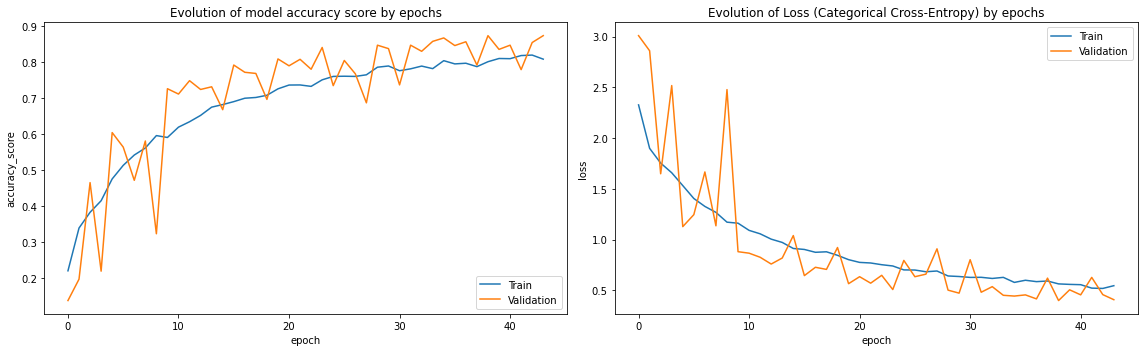

In [135]:
hist = hist1

plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [136]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = mdl1.evaluate(X_val_exp, val_labels_encoded, batch_size=8)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

950/950 [==============================] - 5s 6ms/sample - loss: 0.3771 - accuracy: 0.8758
Validation cross-entropy Loss: 0.37713274598121643
Validation classification Accuracy: 0.87578946


In [137]:
# Obtain cross-entropy loss and accuracy scores on training dataset
loss, accuracy = mdl1.evaluate(X_train_exp, train_labels_encoded, batch_size=8)
print('Training cross-entropy Loss:', loss)
print('Training classification Accuracy:', accuracy)

3800/3800 [==============================] - 21s 5ms/sample - loss: 0.3143 - accuracy: 0.8976
Training cross-entropy Loss: 0.3143069885475071
Training classification Accuracy: 0.8976316


- Above model uses CNN on augmented image of batch size 8. Model attains a validation accuracy of ~87.6% vs training accuracy of 89.8%
- Based on the result of CNN applied on augmented image does certainly outperform previous ML model and simple ANN model
- There is certainly some variability observed in validation accuracy across epochs; however, more importantly, the model is NOT an overfit
- Small batch size (8) was used to ensure we have more number of iterations per epoch
- Another variant we may try using is Gaussian blurred images as input to model training - because we know CNN may perform well on a blurred image vs sharp image due to its underlying mechanism of nullifying effect for digital noise in the context of edge detection of images
- So this time we try with **Gaussian blurring to blur input images and apply CNN to the augmented blurred images**

#### Apply Gaussian blurring

In [26]:
# Training data Pre-processing - Gaussian Blurring - blur the image to remove digital noise
X_train_GBlur = X_train_exp.copy()
for i in range(len(X_train_exp)):
    # Add gaussian blurring
    X_train_GBlur[i] = cv2.GaussianBlur(X_train_exp[i], (5, 5), 0)

In [27]:
# Validation data Pre-processing - Gaussian Blurring - blur the image to remove digital noise
X_val_GBlur = X_val_exp.copy()
for i in range(len(X_val_exp)):
    # Add gaussian blurring
    X_val_GBlur[i] = cv2.GaussianBlur(X_val_exp[i], (5, 5), 0)

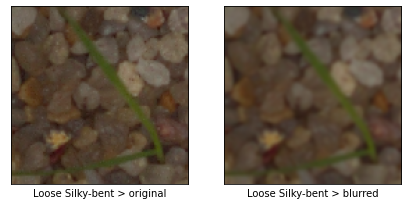

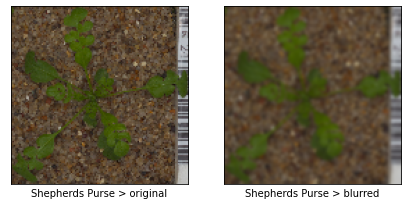

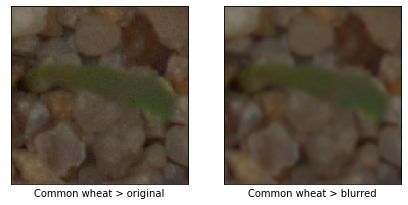

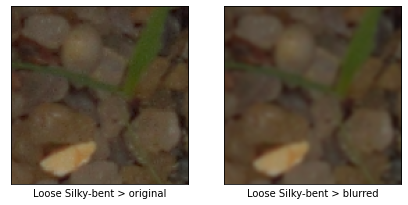

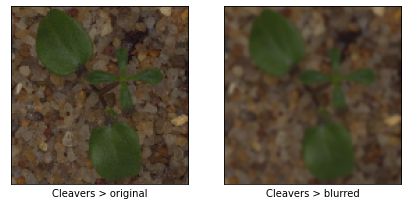

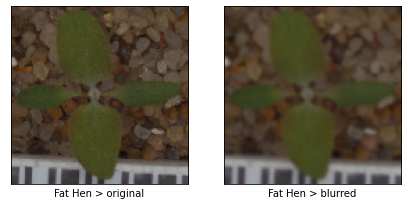

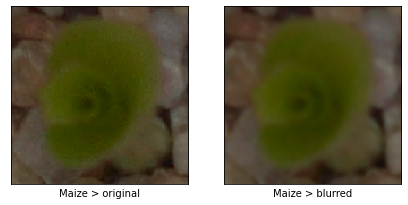

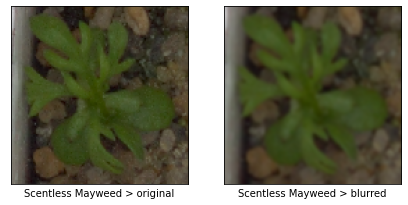

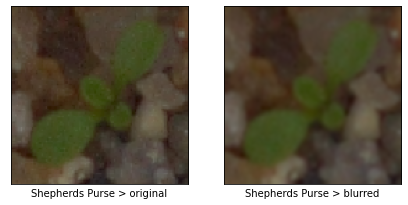

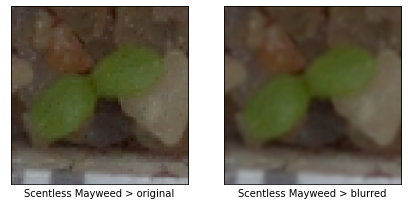

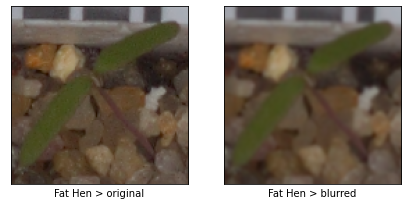

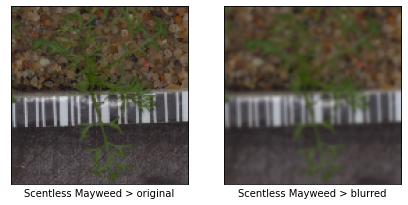

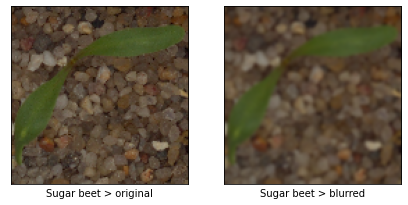

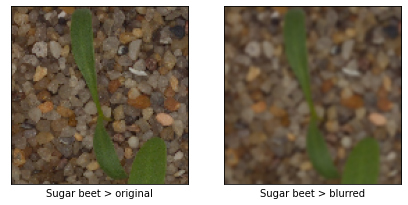

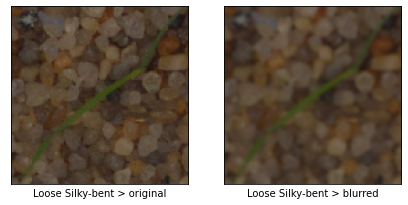

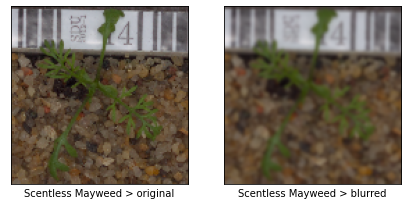

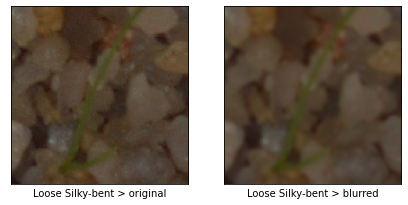

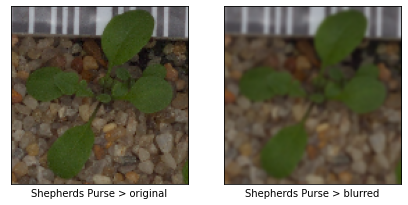

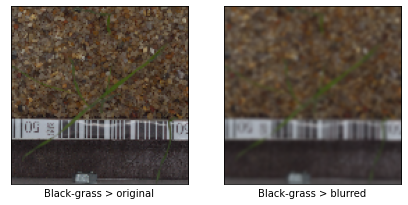

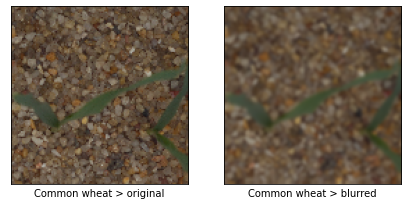

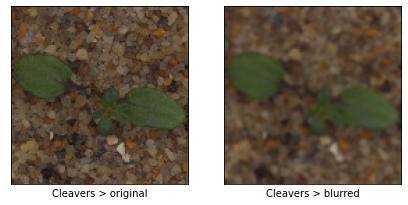

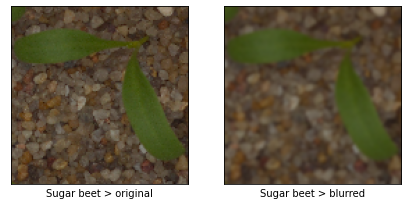

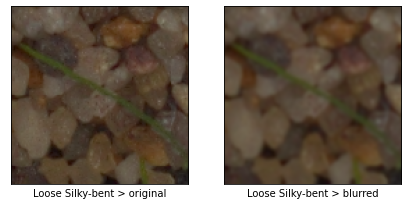

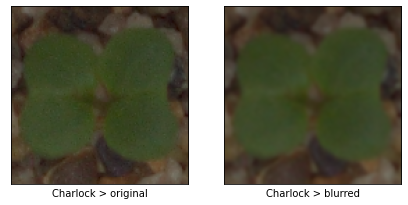

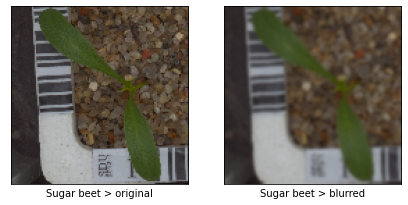

In [29]:
plt.rcParams.update({'figure.max_open_warning': 0})

# Visualize few blurred images from training set
y_train_lab = le.inverse_transform(y_train)

for i in range(25):
    fig = plt.figure(figsize=(7,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    _ = ax1.imshow(X_train_exp[i])
    _ = ax2.imshow(X_train_GBlur[i])
    ax1.set_xlabel(y_train_lab[i]+' > original')
    ax2.set_xlabel(y_train_lab[i]+' > blurred')
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax1.set_yticks([])
    ax2.set_yticks([])
plt.show()

In [192]:
# Clear Keras managed global state memory
tf.keras.backend.clear_session()

# Initialize model
mdl2 = tf.keras.models.Sequential()

# Set up input image size
mdl2.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,)))

# Define input shape in the first layer of the neural network
#mdl2.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(x_train.shape[1:])))

# Add Convolutional layer
mdl2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))
# Add Batch Normalization layer
mdl2.add(tf.keras.layers.BatchNormalization())
# Add Max Pooling layer
mdl2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
mdl2.add(tf.keras.layers.Dropout(rate=0.10))

# Add Convolutional layer
mdl2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))
# Add Batch Normalization layer
mdl2.add(tf.keras.layers.BatchNormalization())
# Add Max Pooling layer
mdl2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
mdl2.add(tf.keras.layers.Dropout(rate=0.10))

# Add Convolutional layer
mdl2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Add Batch Normalization layer
mdl2.add(tf.keras.layers.BatchNormalization())
# Add Max Pooling layer
mdl2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
mdl2.add(tf.keras.layers.Dropout(rate=0.10))

# Add Convolutional layer
mdl2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Add Batch Normalization layer
mdl2.add(tf.keras.layers.BatchNormalization())
# Add Max Pooling layer
mdl2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
mdl2.add(tf.keras.layers.Dropout(rate=0.20))

# Add Max Pooling layer
mdl2.add(tf.keras.layers.GlobalMaxPooling2D())

# Flatten
mdl2.add(tf.keras.layers.Flatten())

# Add FC dense layer
mdl2.add(tf.keras.layers.Dense(units=512, activation='relu'))
# Add FC dense layer
mdl2.add(tf.keras.layers.Dense(units=256, activation='relu'))

# Add Output layer
mdl2.add(tf.keras.layers.Dense(units=train_labels_encoded.shape[1], activation='softmax'))

# Compile model
mdl2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [193]:
mdl2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [194]:
# Augmented image generator
imgdatagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30 #Degree range for random rotations
                                                             , width_shift_range=0.2 #Randomly shift input horizontally
                                                             , height_shift_range=0.2 #Randomly shift input vertically
                                                             , horizontal_flip=True #Randomly flip input horizontally
                                                             , vertical_flip=True #Randomly flip input vertically
                                                            )

In [195]:
# Fit image data generator on training set 
imgdatagen.fit(X_train_GBlur)

# Configure the batch size and prepare the data generator and get batches of training images
train_datagen = imgdatagen.flow(x=X_train_GBlur, y=train_labels_encoded, batch_size=8)

# Configure the batch size and prepare the data generator and get batches of validation images
val_datagen = imgdatagen.flow(x=X_val_GBlur, y=val_labels_encoded, batch_size=8)

In [196]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

In [197]:
# Train model
hist2 = mdl2.fit_generator(generator=train_datagen
                           , epochs=50
                           , steps_per_epoch=len(train_datagen.x)//train_datagen.batch_size
                           , validation_data=val_datagen
                           , validation_steps=len(val_datagen.x)//val_datagen.batch_size
                           , callbacks=[callback]
                           , verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 475 steps, validate for 118 steps
Epoch 1/50
475/475 [==============================] - 174s 366ms/step - loss: 1.7943 - accuracy: 0.3950 - val_loss: 1.9644 - val_accuracy: 0.3633
Epoch 2/50
475/475 [==============================] - 188s 396ms/step - loss: 1.3318 - accuracy: 0.5461 - val_loss: 1.2466 - val_accuracy: 0.5540
Epoch 3/50
475/475 [==============================] - 184s 387ms/step - loss: 1.1152 - accuracy: 0.6197 - val_loss: 2.2034 - val_accuracy: 0.4195
Epoch 4/50
475/475 [==============================] - 188s 396ms/step - loss: 0.9351 - accuracy: 0.6800 - val_loss: 0.9914 - val_accuracy: 0.6377
Epoch 5/50
475/475 [==============================] - 180s 380ms/step - loss: 0.8298 - accuracy: 0.7108 - val_loss: 1.2504 - val_accuracy: 0.5720
Epoch 6/50
475/475 [==============================] - 181s 382ms/step - loss: 0.7171 - accuracy: 0.7461 - val_loss: 0.6934 - val_accuracy: 0.7680
Epoch 7/50
475/475 [==========

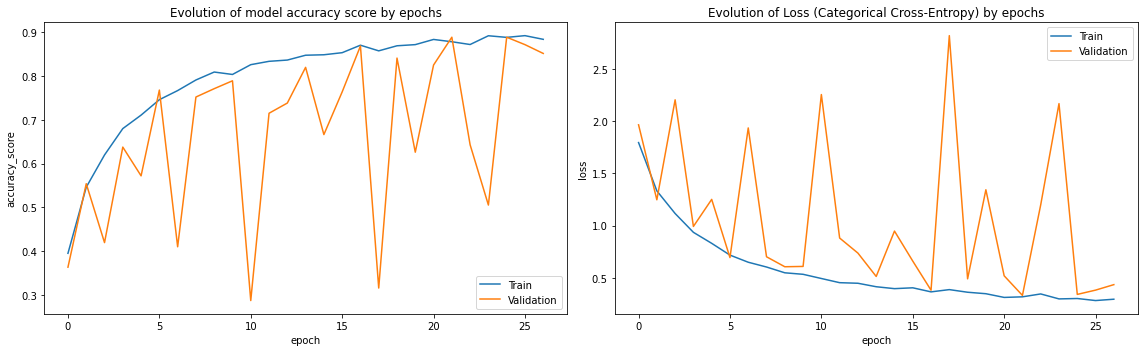

In [200]:
hist = hist2

plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [198]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = mdl2.evaluate(X_val_GBlur, val_labels_encoded, batch_size=8)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

950/950 [==============================] - 10s 10ms/sample - loss: 0.3128 - accuracy: 0.8937
Validation cross-entropy Loss: 0.31283662708182086
Validation classification Accuracy: 0.8936842


In [199]:
# Obtain cross-entropy loss and accuracy scores on training dataset
loss, accuracy = mdl2.evaluate(X_train_GBlur, train_labels_encoded, batch_size=8)
print('Training cross-entropy Loss:', loss)
print('Training classification Accuracy:', accuracy)

3800/3800 [==============================] - 39s 10ms/sample - loss: 0.2119 - accuracy: 0.9213
Training cross-entropy Loss: 0.21187343874554102
Training classification Accuracy: 0.9213158


- Above model is CNN applied on augmented images out of the blurred images
- The performance of this one is a bit better than the previous model (which was applied on non-blurred augmented images)
- Model achieved validation accuracy of 89.4% vs training accuracy of 92.1%
- However, notably the validation accuracy has a lot more variability across epochs vs training accuracy

In [32]:
# Clear Keras managed global state memory
tf.keras.backend.clear_session()

# Initialize model
mdl3 = tf.keras.models.Sequential()

# Set up input image size
mdl3.add(tf.keras.layers.InputLayer(input_shape=(image_size,image_size,3,)))

# Define input shape in the first layer of the neural network
#mdl3.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(x_train.shape[1:])))

# Add Convolutional layer
mdl3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
# Add Batch Normalization layer
mdl3.add(tf.keras.layers.BatchNormalization())
# Add Max Pooling layer
mdl3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
mdl3.add(tf.keras.layers.Dropout(rate=0.10))

# Add Convolutional layer
mdl3.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Add Batch Normalization layer
mdl3.add(tf.keras.layers.BatchNormalization())
# Add Max Pooling layer
mdl3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
mdl3.add(tf.keras.layers.Dropout(rate=0.10))

# Add Convolutional layer
mdl3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Add Batch Normalization layer
mdl3.add(tf.keras.layers.BatchNormalization())
# Add Max Pooling layer
mdl3.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# Add dropout layer
mdl3.add(tf.keras.layers.Dropout(rate=0.20))

# Add Max Pooling layer
mdl3.add(tf.keras.layers.GlobalMaxPooling2D())

# Flatten
mdl3.add(tf.keras.layers.Flatten())

# Add FC dense layer
mdl3.add(tf.keras.layers.Dense(units=256, activation='relu'))
# Add dropout layer
mdl3.add(tf.keras.layers.Dropout(rate=0.40))
# Add FC dense layer
mdl3.add(tf.keras.layers.Dense(units=128, activation='relu'))
# Add dropout layer
mdl3.add(tf.keras.layers.Dropout(rate=0.30))

# Add Output layer
mdl3.add(tf.keras.layers.Dense(units=train_labels_encoded.shape[1], activation='softmax'))

# Compile model
mdl3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

NameError: name 'train_labels_encoded' is not defined

In [ ]:
mdl3.summary()

In [30]:
# Training data Pre-processing - Gaussian Blurring - blur the image to remove digital noise
X_train_GBlur = X_train_exp.copy()
for i in range(len(X_train_exp)):
    # Add gaussian blurring
    X_train_GBlur[i] = cv2.GaussianBlur(X_train_exp[i], (7, 7), 0)

In [31]:
# Validation data Pre-processing - Gaussian Blurring - blur the image to remove digital noise
X_val_GBlur = X_val_exp.copy()
for i in range(len(X_val_exp)):
    # Add gaussian blurring
    X_val_GBlur[i] = cv2.GaussianBlur(X_val_exp[i], (7, 7), 0)

In [205]:
# Augmented image generator
imgdatagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20 #Degree range for random rotations
                                                             , width_shift_range=0.2 #Randomly shift input horizontally
                                                             , height_shift_range=0.2 #Randomly shift input vertically
                                                             , horizontal_flip=True #Randomly flip input horizontally
                                                             , vertical_flip=True #Randomly flip input vertically
                                                            )

In [206]:
# Fit image data generator on training set 
imgdatagen.fit(X_train_GBlur)

# Configure the batch size and prepare the data generator and get batches of training images
train_datagen = imgdatagen.flow(x=X_train_GBlur, y=train_labels_encoded, batch_size=32)

# Configure the batch size and prepare the data generator and get batches of validation images
val_datagen = imgdatagen.flow(x=X_val_GBlur, y=val_labels_encoded, batch_size=32)

In [207]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min', verbose=1)

In [208]:
# Train model
hist3 = mdl3.fit_generator(generator=train_datagen
                           , epochs=50
                           , steps_per_epoch=len(train_datagen.x)//train_datagen.batch_size
                           , validation_data=val_datagen
                           , validation_steps=len(val_datagen.x)//val_datagen.batch_size
                           , callbacks=[callback]
                           , verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 118 steps, validate for 29 steps
Epoch 1/50
118/118 [==============================] - 327s 3s/step - loss: 2.0144 - accuracy: 0.3442 - val_loss: 2.5177 - val_accuracy: 0.1390
Epoch 2/50
118/118 [==============================] - 327s 3s/step - loss: 1.2645 - accuracy: 0.5677 - val_loss: 2.7923 - val_accuracy: 0.0571
Epoch 3/50
118/118 [==============================] - 329s 3s/step - loss: 1.0402 - accuracy: 0.6396 - val_loss: 3.0800 - val_accuracy: 0.0582
Epoch 4/50
118/118 [==============================] - 327s 3s/step - loss: 0.9120 - accuracy: 0.6863 - val_loss: 2.1857 - val_accuracy: 0.2349
Epoch 5/50
118/118 [==============================] - 330s 3s/step - loss: 0.8138 - accuracy: 0.7182 - val_loss: 1.1173 - val_accuracy: 0.6487
Epoch 6/50
118/118 [==============================] - 320s 3s/step - loss: 0.7487 - accuracy: 0.7407 - val_loss: 1.5684 - val_accuracy: 0.4925
Epoch 7/50
118/118 [=============================

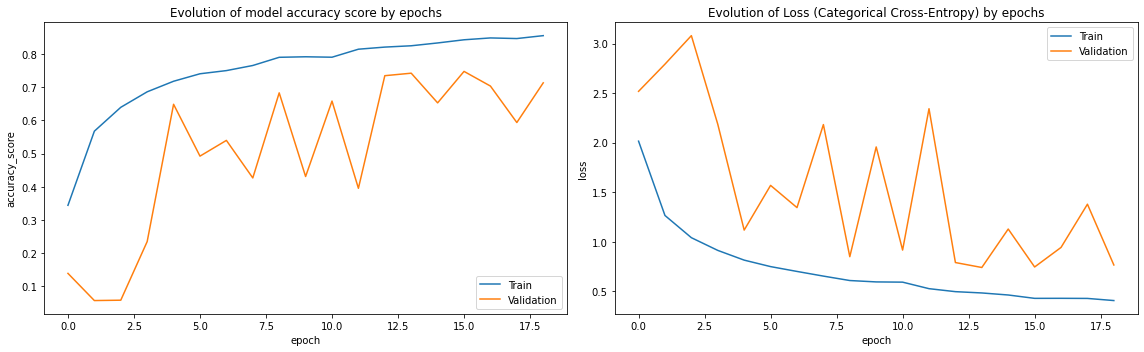

In [210]:
hist = hist3

plt.figure(figsize=(16,5))
# History of accuracy score
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of model accuracy score by epochs')
plt.ylabel('accuracy_score')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#---------------------------------
# History of Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

In [211]:
# Obtain cross-entropy loss and accuracy scores on validation dataset
loss, accuracy = mdl3.evaluate(X_val_GBlur, val_labels_encoded, batch_size=32)
print('Validation cross-entropy Loss:', loss)
print('Validation classification Accuracy:', accuracy)

950/950 [==============================] - 10s 10ms/sample - loss: 0.6742 - accuracy: 0.7653
Validation cross-entropy Loss: 0.6742226046010068
Validation classification Accuracy: 0.76526314


In [212]:
# Obtain cross-entropy loss and accuracy scores on training dataset
loss, accuracy = mdl3.evaluate(X_train_GBlur, train_labels_encoded, batch_size=32)
print('Training cross-entropy Loss:', loss)
print('Training classification Accuracy:', accuracy)

3800/3800 [==============================] - 38s 10ms/sample - loss: 0.6162 - accuracy: 0.7845
Training cross-entropy Loss: 0.6161996385925694
Training classification Accuracy: 0.78447366


- Above CNN model doesn't perform as good as the previous one with 76.5% validation accuracy vs 78.4% training accuracy
- We will stick with the previous model for the best model

#### Model evaluation

In [274]:
# Store the best model
best_model = mdl2

In [310]:
# Prepare target data for model evaluation
y_val_actual = np.argmax(val_labels_encoded, axis=1)
y_val_pred = np.argmax(best_model.predict(X_val_GBlur, batch_size=8), axis=1)

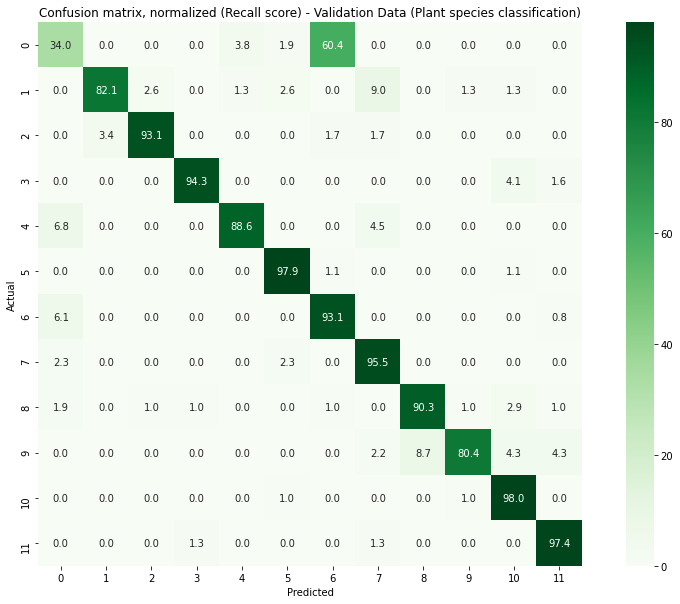

In [315]:
# Set the figure size
plt.figure(figsize=(16, 10))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=y_val_actual, y_pred=y_val_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='.1f', square=True)\
.set_title('Confusion matrix, normalized (Recall score) - Validation Data (Plant species classification)')
_ = plt.xlabel('Predicted')
_ = plt.ylabel('Actual')

In [312]:
# Print the classification report
print(classification_report(y_val_actual, y_val_pred))

              precision    recall  f1-score   support

           0       0.56      0.34      0.42        53
           1       0.97      0.82      0.89        78
           2       0.95      0.93      0.94        58
           3       0.98      0.94      0.96       122
           4       0.93      0.89      0.91        44
           5       0.95      0.98      0.96        95
           6       0.78      0.93      0.85       131
           7       0.78      0.95      0.86        44
           8       0.96      0.90      0.93       103
           9       0.93      0.80      0.86        46
          10       0.89      0.98      0.93        99
          11       0.93      0.97      0.95        77

    accuracy                           0.89       950
   macro avg       0.88      0.87      0.87       950
weighted avg       0.89      0.89      0.89       950



In [313]:
print('ROC AUC score:', roc_auc_score(y_val_actual, best_model.predict_proba(X_val_GBlur), multi_class='ovr').round(4))

ROC AUC score: 0.9931


In [314]:
pd.DataFrame({'Code':le.transform(le.classes_), 'Species':le.classes_})

Code                    Species
0      0                Black-grass
1      1                   Charlock
2      2                   Cleavers
3      3           Common Chickweed
4      4               Common wheat
5      5                    Fat Hen
6      6           Loose Silky-bent
7      7                      Maize
8      8          Scentless Mayweed
9      9            Shepherds Purse
10    10  Small-flowered Cranesbill
11    11                 Sugar beet

#### Comments on evaluation metrics:
- Model has an overall accuracy of 89% with F1-score being nearly or more than 90% for most of the plan species prediction
- The species for which model didn't perform well are Black-grass (34% recall), Shepherds Purse (80% recall) and Charlock (82% recall)
- Model went wrong ~60% of the time while classifying a Black-grass plant; confusing with Loose Silky-bent (refer Confusion matrix). Images of Black-grass and Loose Silky-bent look very similar. Moreover sample size for Black-grass plant in the validation set is small too (support = 53 out of 950). Hence it may be expected the model to wrongly classify Black-grass most of the time.
- However, interestingly the other way round is not true - i.e., Loose Silky-bent is mostly correctly classified underpinned by the fact that the sample size is the largest (support = 131) for this class in the validation set.

#### Model comparison and Conclusion:
- Best ML model turned out to be Support Vector Classifier (SVC) having 51% validation accuracy vs 85% training accuracy. However, this is unusable given that the model being an overfit.
- SVC being generally robust against the presence large number of features it performed the best among the rest of ML models
- ANN models performed slightly better than the SVC model having ~57% validation accuracy vs ~99% training accuracy. But again this suffers from the problem of overfitting.
- Given the presence of digital noise, small sample size and shades in the plant images and considering that CNN is based on gradient of image pixel intensities, CNN applied on the augmented images of the pre-processed blurry images (Gaussian Blur) does perform the best among all the models considered for this classification task.
- This best model yields validation accuracy of 89% vs training accuracy of 92%
- There seems to be a presence of variability in the validation accuracy for CNN - but we can certainly try other variations of the model (filtering, blurring etc.) to alleviate it and thrive for better accuracy.

#### Pickle best model for future use

In [275]:
# serialize model to JSON
JSONmodel = best_model.to_json()

# save the model architecture to JSON file
with open('Plant_Image_Classifier_Model.json', 'w') as JSONfile:
    JSONfile.write(JSONmodel)

#saving the weights of the model
best_model.save_weights('Plant_Image_Classifier_Weights.h5')

#### Prediction of plant species for an input plant image

In [276]:
# Read in test image files and pre-process
test_image, _, test_file, _ = \
            read_images_and_preprocess('Dataset - Prediction/Prediction', image_size=image_size)

In [277]:
print('Filename:', test_file)
print('Input test image count:', len(test_image))
print('Size of input test image:', test_image.shape)

Filename: ['Predict.png']
Input test image count: 1
Size of input test image: (1, 128, 128, 3)


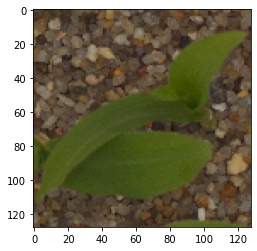

In [278]:
# Visualize raw input test image
_ = plt.imshow(test_image.squeeze())

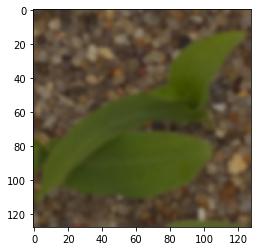

In [279]:
# Prepare test input image for model ingestion prior to prediction - i.e., blur image (Gaussian Blurring)
test_image_blurred = cv2.GaussianBlur(test_image.squeeze(), (5, 5), 0).reshape(1, image_size, image_size, 3)
_ = plt.imshow(test_image_blurred.squeeze())

In [280]:
# Predict class membership of the test image
pred = best_model.predict(x=test_image_blurred)
print('\n******  Predicted species for input plant image:', le.inverse_transform(np.array(np.argmax(pred)).reshape(1,)), \
      '  ******')


******  Predicted species for input plant image: ['Maize']   ******


## Project 1 (Part 2)
### Question: Explain in depth why CNN outperforms neural networks which in turn outperform supervised learning models when it comes to image classification. 

- Neural Network model (a.k.a. ANN) is a class of non-linear models and works iteratively through feed-forward and backpropagation across epochs, and learns continuously in smaller batches. However, this requires large amount of data to train, and can work with large number of features especially for image analysis.

- CNN is a class of ANNs. As for CNN's architecture, it involves an additional part of data preparation (ConvNet) along with usual ANN for model training in the end. In this way, CNN has an added power of handling noisy image data before data being fed into ANN model.

- Given our task for image classification of plan seedlings, data does contain colored images with noises, light shades etc. 

- ANN works using simply the distribution of pixel intensities and that may not be sufficient to classify images properly. While CNN works using the gradient (change) in pixel intensities that is much more effective for edge detection and hence image classification.

- Moreover, CNN can address reduction in digital noise through filtering (Gaussian blurring) and hence is more effective in accurately predicting image class.

- Notably we have only 4750 images in all for the image classification. We may need more images to learn image classifier. This may be achieved through image augmentation. In addition, image augmentation brings in varieties in the dataset and can help learn CNN model better on unseen data.

- For these above reasons, CNN combined with image augmentation does outperform ANN by a wide margin for this image classification task.

- Comparing ANN and traditional Machine Learning models, ANN is no doubt more apt for typical image classification tasks over existing ML models due to ANN's network architecture and mechanism as noted earlier. In ANN, the weights can be learned through backpropagation over epochs in smaller batches - while ML models are difficult to train when you have smaller sample size with many features.

## <center><font color='green'>*******End of Project Solution*******</font></center>